In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout ,BatchNormalization
from keras import backend as K
from tqdm import tqdm_notebook,tnrange
from skimage.util import pad

# 准备
img_size_ori = 101
img_size_target = 256

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
def upsample_v2(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (256, 256), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res    
def reflect_pad(img):
    return pad(resize(img, (101*2, 101*2), mode='constant', preserve_range=True),27,'reflect')

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

train_df = pd.read_csv("/home/zhangs/lyc/salt/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/home/zhangs/lyc/salt/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]#将生成id不在train中的样本id集合
train_df["images"] = [np.array(load_img("/home/zhangs/lyc/salt/train/images/{}.png".format(idx), grayscale=True))/ 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("/home/zhangs/lyc/salt/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
# 将深度信息放入训练图像
MAX_DEPTH = max(train_df["z"])
print('**** Max depth in train set is :'+str(MAX_DEPTH))
train_df["depth"] = [np.ones_like(train_df.loc[i]["images"]) * train_df.loc[i]["z"] / MAX_DEPTH
                     for i in tqdm_notebook(train_df.index)]

# Image in layer1 + depth in layer2
train_df["images_d"] = [np.dstack((train_df["images"][i],train_df["depth"][i])) for i in tqdm_notebook(train_df.index)]
train_df["images_d"][0].shape
# Free up some RAM
del depths_df
# del train_df["images"]
# Sanity check
train_df.head()

/home/zhangs/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/home/zhangs/anaconda3/lib/python3.5/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



**** Max depth in train set is :959


,z,images,masks,coverage,coverage_class,depth,images_d
id,,,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0,"[[0.8790406673618353, 0.8790406673618353, 0.87...","[[[0.5254901960784314, 0.8790406673618353], [0..."
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6,"[[0.8279457768508863, 0.8279457768508863, 0.82...","[[[0.3411764705882353, 0.8279457768508863], [0..."
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10,"[[0.4880083420229406, 0.4880083420229406, 0.48...","[[[0.5686274509803921, 0.4880083420229406], [0..."
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2,"[[0.7580813347236705, 0.7580813347236705, 0.75...","[[[0.5411764705882353, 0.7580813347236705], [0..."
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1,"[[0.8310740354535975, 0.8310740354535975, 0.83...","[[[0.06666666666666667, 0.8310740354535975], [..."


## Split the no use cross validation
May be not necessary

In [ ]:
ids_train, ids_valid = train_test_split(
    train_df.index.values,
    test_size=0.12, stratify=train_df.coverage_class, random_state=1337)
my_test_pd = train_df.loc[train_df.index.isin(ids_valid)]
train_df = train_df.loc[train_df.index.isin(ids_train)]

In [ ]:
print(my_test_pd.shape)
print(train_df.shape)


# Cut the train and valid set ，use K-flods

In [2]:
K_flods = 8
from sklearn.model_selection import StratifiedKFold
X = train_df.index.values
y = train_df.coverage_class
skf = StratifiedKFold(n_splits=K_flods,random_state=1337)
skf.get_n_splits(X, y)
print(skf)
ids_train,ids_valid,x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test=[[] for x in range(10)]
# X_whole = np.array(train_df.images_d.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 2)
# y_whole = np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

StratifiedKFold(n_splits=8, random_state=1337, shuffle=False)


In [3]:
X_whole = np.array(train_df.images.map(reflect_pad).tolist()).reshape(-1, 256, 256, 1)
y_whole = np.array(train_df.masks.map(reflect_pad).tolist()).reshape(-1, 256, 256, 1)
# xpad1=pad(resize(x_train[0,:,:,0], (101*2, 101*2), mode='constant', preserve_range=True),27,'reflect')
# xpad2=pad(resize(x_train[1,:,:,0], (101*2, 101*2), mode='constant', preserve_range=True),27,'reflect')
# print(xpad1.shape)
# axs[2].imshow(xpad1,  cmap="Greys")
# axs[3].imshow(xpad2,  cmap="Greys")
# plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15,5))
axs[0].imshow(X_whole[1,:,:,0],  cmap="Greys")
axs[1].imshow(y_whole[1,:,:,0],  cmap="Greys")
axs[2].imshow(np.array(train_df.images.map(upsample).tolist()).reshape(-1, 128, 128, 1)[1,:,:,0],  cmap="Greys")
axs[3].imshow(np.array(train_df.masks.map(upsample).tolist()).reshape(-1, 128, 128, 1)[1,:,:,0],  cmap="Greys")
plt.show()

In [4]:
for i,[train_index, test_index] in enumerate(skf.split(X, y)):
    print("the %dth flod:"%i)
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    ids_train.append(X[train_index])
    ids_valid.append(X[test_index])
    #
    x_train.append(X_whole[train_index])
    x_valid.append(X_whole[test_index])
    #
    y_train.append(y_whole[train_index])
    y_valid.append(y_whole[test_index]) 
    #
    cov_train.append(train_df.coverage.values[train_index]) 
    cov_test.append(train_df.coverage.values[test_index])
    #
    depth_train.append(train_df.z.values[train_index]) 
    depth_test.append(train_df.z.values[test_index]) 
    
    if i == 1:
        break
del X_whole,y_whole
print(len(x_train))
print(x_train[0].shape)

the 0th flod:
TRAIN: (3496,) TEST: (504,)
the 1th flod:
TRAIN: (3497,) TEST: (503,)
2
(3496, 256, 256, 1)


In [ ]:
# 画各个flods的salt分布图，检验k-flods是否正确
def plot_flods_coverage(cov,flods_num=5,mode='train'):
    fig, axs = plt.subplots(1, flods_num+1, figsize=(15,5))
    sns.distplot(train_df.coverage, kde=False, ax=axs[0])
    for i in range(1,flods_num+1):
        sns.distplot(cov[i-1], bins=10, kde=False, ax=axs[i])
        axs[i].set_xlabel("Coverage of k%d"%(i-1))
    plt.suptitle("Salt coverage of k-flods "+mode)
    axs[0].set_xlabel("Coverage")
    plt.show()
    

In [ ]:
plot_flods_coverage(cov_train,flods_num=7,mode='train')

In [ ]:
plot_flods_coverage(cov_test,flods_num=5,mode='test')

In [ ]:
# sns.distplot(train_df.z, label="Train")
# sns.distplot(test_df.z, label="Test")
# plt.legend()
# plt.title("Depth distribution")
# plt.show()

In [ ]:
# max_images = 60
# grid_width = 15
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(train_df.index[:max_images]):
#     img = train_df.loc[idx].images
#     mask = train_df.loc[idx].masks
#     ax = axs[int(i / grid_width), i % grid_width]
#     ax.imshow(img, cmap="Greys")
#     ax.imshow(mask, alpha=0.3, cmap="Greens")
#     ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
#     ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
#     ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
# plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
# plt.show()

In [ ]:
# ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
#     train_df.index.values,
#     np.array(train_df.images_d.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 2), 
#     np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
#     train_df.coverage.values,
#     train_df.z.values,
#     test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [ ]:
from skimage.util import pad
fig, axs = plt.subplots(1, 4, figsize=(15,5))
axs[0].imshow(x_train[0,:,:,0],  cmap="Greys")
axs[1].imshow(x_train[1,:,:,0],  cmap="Greys")
 
xpad1=pad(resize(x_train[0,:,:,0], (101*2, 101*2), mode='constant', preserve_range=True),27,'reflect')
xpad2=pad(resize(x_train[1,:,:,0], (101*2, 101*2), mode='constant', preserve_range=True),27,'reflect')
print(xpad1.shape)
axs[2].imshow(xpad1,  cmap="Greys")
axs[3].imshow(xpad2,  cmap="Greys")
plt.show()

In [ ]:
# tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
# tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
# fix, axs = plt.subplots(1, 2, figsize=(15,5))
# axs[0].imshow(tmp_img, cmap="Greys")
# axs[0].set_title("Original image")
# axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
# axs[1].set_title("Scaled image")

# Data argumantant

In [5]:
for i in range(2):
    x_l_r_flip = [np.fliplr(x) for x in x_train[i]]
    y_l_r_flip = [np.fliplr(x) for x in y_train[i]]
    # x_u_d_flip = [np.flipud(x) for x in x_train]
    # y_u_d_flip = [np.flipud(x) for x in y_train]
    # x_t = [np.reshape(np.transpose(x),(img_size_target,img_size_target,2)) for x in x_train]
    # y_t = [np.reshape(np.transpose(x),(img_size_target,img_size_target,1)) for x in y_train]
    # x_train = np.append(x_train, x_u_d_flip, axis=0)
    # y_train = np.append(y_train, y_u_d_flip, axis=0)
    # x_train = np.append(x_train, x_t, axis=0)
    # y_train = np.append(y_train, y_t, axis=0)
    x_train[i] = np.append(x_train[i], x_l_r_flip, axis=0)
    y_train[i] = np.append(y_train[i], y_l_r_flip, axis=0)

In [6]:
print(x_train[0].shape)

(6992, 256, 256, 1)


## 对比度增强

In [ ]:
# from skimage import exposure
# contrast = [np.dstack([np.array(exposure.rescale_intensity(
#     img[:,:,0],in_range=(np.percentile(img[:,:,0], (1, 99))[0],np.percentile(img[:,:,0], (1, 99))[1]))),img[:,:,1]]) 
#             for img in tqdm_notebook(x_train)]
# contrast = np.array(contrast)
# x_train = np.append(x_train, contrast, axis=0)
# y_train = np.append(y_train, y_train, axis=0)
# x_train = np.append(x_train, x_l_r_flip, axis=0)
# y_train = np.append(y_train, y_l_r_flip, axis=0)
# print(x_train.shape)
# print(y_train.shape)
# del contrast


In [ ]:
plt.subplot(1,2,1)
plt.imshow(x_train[110,:,:,0], cmap='binary')
plt.title('Original Image')
plt.subplot(1,2,2)    
plt.imshow(contrast[110,:,:,0], cmap='binary')
plt.title('Contrast stretching')
print(contrast.shape)
print(contrast[110,60:64,60:64,1])
print(x_train[110,60:64,60:64,1])

In [ ]:
import random
def random_shiff(x_train,y_train):
    length = x_train.shape[0]
    len_list = list(range(length))
    shiff_index = np.random.shuffle(len_list)
    return x_train[shiff_index:,:,:],y_train[shiff_index:,:,:]
x_train,y_train = random_shiff(x_train,y_train)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(np.array(x_t).shape)

In [ ]:
fix, axs = plt.subplots(2, 2, figsize=(15,5))
print(x_train.shape)
axs[0][0].imshow(x_train[10,:,:,0], cmap="Greys")
axs[0][1].imshow(y_train[10,:,:,0], cmap="Greys")
axs[1][0].imshow((np.fliplr(x_train[10,:,:,0])), cmap="Greys")
axs[1][1].imshow((np.fliplr(y_train[10,:,:,0])), cmap="Greys")

In [ ]:
# from PIL import Image, ImageEnhance, ImageOps, ImageFile
# def randomRotation(image, mode=Image.BICUBIC):
#     """
#      对图像进行随机任意角度(0~360度)旋转
#     :param mode 邻近插值,双线性插值,双三次B样条插值(default)
#     :param image PIL的图像image
#     :return: 旋转转之后的图像
#     """
#     random_angle = np.random.randint(1, 360)
#     return image.rotate(random_angle, mode)

In [ ]:
# fig, axs = plt.subplots(2, 10, figsize=(15,3))
# for i in range(10):
#     axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
#     axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
#     axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
#     axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
# fig.suptitle("Top row: original images, bottom row: augmented images")

In [ ]:
x_train[0][..., :1].shape


# Model build

In [12]:
from keras.losses import binary_crossentropy

def mean_iou(Y_true, Y_pred, score_thres=0.5):
    """Compute mean(IoU) metric
    IoU = intersection / union
    
    For each (mask)threshold in provided range:
     - convert probability mask to boolean mask based on given threshold
     - score the mask 1 if(IoU > score_threshold(0.5))
    Take the mean of the scoress

    https://www.tensorflow.org/api_docs/python/tf/metrics/mean_iou
    """
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        Y_pred_bool = tf.to_int32(Y_pred > t) # boolean mask by threshold
        score, update_op = tf.metrics.mean_iou(Y_true, Y_pred_bool, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            score = tf.identity(score) #!! use identity to transform score to tensor
        prec.append(score) 
        
    return K.mean(K.stack(prec), axis=0)

def focal_loss(y_true, y_pred):
    gamma=0.5
    alpha=0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

from keras import backend as K

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, K.sigmoid(y_pred)) + dice_loss(y_true, K.sigmoid(y_pred))

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [13]:
dpt = 5
DPT_SIZE = int(img_size_target/pow(2,dpt))

In [13]:
from segmentation_models.segmentation_models import Unet
from segmentation_models.segmentation_models.utils import set_trainable

In [15]:
help()


Welcome to Python 3.5's help utility!

If this is your first time using Python, you should definitely check out
the tutorial on the Internet at http://docs.python.org/3.5/tutorial/.

Enter the name of any module, keyword, or topic to get help on writing
Python programs and using Python modules.  To quit this help utility and
return to the interpreter, just type "quit".

To get a list of available modules, keywords, symbols, or topics, type
"modules", "keywords", "symbols", or "topics".  Each module also comes
with a one-line summary of what it does; to list the modules whose name
or summary contain a given string such as "spam", type "modules spam".

help> 

You are now leaving help and returning to the Python interpreter.
If you want to ask for help on a particular object directly from the
interpreter, you can type "help(object)".  Executing "help('string')"
has the same effect as typing a particular string at the help> prompt.


In [16]:
history_all = []
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i in range(0,1): 
    model = Unet(input_shape=(256,256,3),backbone_name='resnet34', encoder_weights='imagenet', 
                 freeze_encoder=False,decoder_use_batchnorm=True)
    #model.load_weights('res50_keras.model')
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #sgd  = SGD(lr=0.0005, momentum=0.9, decay=0.0001, nesterov=False)
    model.compile(loss=bce_dice_loss, optimizer=adam, metrics=[my_iou_metric])
    #model.compile(loss=keras_lovasz_hinge, optimizer=sgd, metrics=[my_iou_metric])

    model.summary()
    # continue training    "trained_models/%dth_flod.model"%i
    early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max', patience=10, verbose=1)
    model_checkpoint = ModelCheckpoint("trained_models/%dth_flod.model"%i,monitor='val_my_iou_metric', 
                                   mode = 'max',  save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', 
                                   mode = 'max', factor=0.1, patience=5, min_lr=0.000001, verbose=1)

    history = model.fit(np.repeat(x_train[i][..., :1],3,axis=-1),
                          y_train[i],
                          validation_data=(np.repeat(x_valid[i][..., :1],3,axis=-1),
                          y_valid[i]), 
                          epochs=100,
                          batch_size=32,
                          callbacks=[model_checkpoint, reduce_lr,early_stopping])
    history_all.append(history)
    axs[i][0].plot(history.epoch, history.history["loss"], label="Train loss")
    axs[i][0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    axs[i][1].plot(history.epoch, history.history["acc"], label="Train accuracy")
    axs[i][1].plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
    axs[i][2].plot(history.epoch, history.history["mean_iou"], label="Train iou")
    axs[i][2].plot(history.epoch, history.history["val_mean_iou"], label="Validation iou")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_69 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_69[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

6992/6992 [==============================] - 113s 16ms/step - loss: 1.3087 - my_iou_metric: 0.4786 - val_loss: 1.2611 - val_my_iou_metric: 0.6401

Epoch 00001: val_my_iou_metric improved from -inf to 0.64008, saving model to trained_models/0th_flod.model
Epoch 2/100
6992/6992 [==============================] - 105s 15ms/step - loss: 1.2344 - my_iou_metric: 0.6965 - val_loss: 1.2251 - val_my_iou_metric: 0.6984

Epoch 00002: val_my_iou_metric improved from 0.64008 to 0.69841, saving model to trained_models/0th_flod.model
Epoch 3/100
6992/6992 [==============================] - 105s 15ms/step - loss: 1.2135 - my_iou_metric: 0.7422 - val_loss: 1.2035 - val_my_iou_metric: 0.7292

Epoch 00003: val_my_iou_metric improved from 0.69841 to 0.72917, saving model to trained_models/0th_flod.model
Epoch 4/100
6992/6992 [==============================] - 105s 15ms/step - loss: 1.1998 - my_iou_metric: 0.7705 - val_loss: 1.2000 - val_my_iou_metric: 0.7496

Epoch 00004: val_my_iou_metric improved from 0

KeyboardInterrupt: 

In [ ]:
plt.show()

# Predit with K-folds

In [20]:
def predit_with_kfolds(K_flods,x_img):
    preds_valid_all = []
    for i in range(K_flods):
        model_flods = load_model("trained_models/%dth_flod.model"%i, custom_objects={'mean_iou': mean_iou})
    #     model.append(model_flods)
        #此处的validation为第0组flod
        preds_valid_flods = model_flods.predict(np.repeat(x_img,3,axis=-1))
        print(preds_valid_flods.shape)
        preds_valid_flods = np.array([downsample(x) for x in preds_valid_flods[:,27:229,27:229,:]])
        print(preds_valid_flods.shape)
        preds_valid_all.append(preds_valid_flods)
    preds_valid = (preds_valid_all[0]+preds_valid_all[1]+preds_valid_all[2]+preds_valid_all[3]+preds_valid_all[4])/5
    return preds_valid

def predit_with_one_fold(model_num,x_img):
    model_flods = load_model("trained_models/%dth_flod.model"%model_num, custom_objects=
                             {'my_iou_metric': my_iou_metric,'bce_dice_loss':bce_dice_loss})
    #     model.append(model_flods)
        #此处的validation为第0组flod
    preds_valid_flods = model_flods.predict(np.repeat(x_img,3,axis=-1))
    print(preds_valid_flods.shape)
    preds_valid_flods = np.array([downsample(x) for x in preds_valid_flods[:,27:229,27:229,:]])
    print(preds_valid_flods.shape)
    return preds_valid_flods

In [19]:
valid_x = np.array(x_valid.images.map(reflect_pad).tolist()).reshape(-1, 256, 256, 1)
valid_y = np.array(y_valid.masks.map(reflect_pad).tolist()).reshape(-1, 256, 256, 1)
valid_x.shape

AttributeError: 'list' object has no attribute 'images'

In [22]:
np.array(x_valid[0]).shape

(504, 256, 256, 1)

### one model predit

In [21]:
preds_valid = predit_with_one_fold(0,x_valid[0])
y_valid = np.array([downsample(x) for x in y_valid[0]])

(504, 256, 256, 1)
(504, 101, 101, 1)


In [22]:
y_valid.shape

(504, 101, 101, 1)

In [11]:
model_flods = load_model("trained_models/0th_flod.model")
preds_valid_flods = model_flods.predict(np.repeat(x_valid[0][..., :1],3,axis=-1))
print(preds_valid_flods.shape)
preds_valid = np.array([downsample(x) for x in preds_valid_flods[:,27:229,27:229,:]])
print(preds_valid_flods.shape)

ValueError: Unknown loss function:bce_dice_loss

In [ ]:
y_valid = np.array([downsample(x) for x in  y_valid[0]])

In [ ]:
preds_valid = predit_with_kfolds(K_flods,valid_x)
# preds_valid_all = []
# for i in range(K_flods):
#     model_flods = load_model("trained_models/%dth_flod.model"%i, custom_objects={'mean_iou': mean_iou})
# #     model.append(model_flods)
#     #此处的validation为第0组flod
#     preds_valid_flods = model_flods.predict({'img': x_valid[0][..., :1], 
#                             'depth': x_valid[0][:, 60:60+DPT_SIZE, 60:60+DPT_SIZE, 1:]}).reshape(-1, img_size_target, img_size_target)
#     preds_valid_flods = np.array([downsample(x) for x in preds_valid_flods])
#     preds_valid_all.append(preds_valid_flods)
# preds_valid = (preds_valid_all[0]+preds_valid_all[1]+preds_valid_all[2]+preds_valid_all[3]+preds_valid_all[4])/5
y_valid = np.array([downsample(x) for x in valid_y])

In [ ]:
preds_valid.shape

In [ ]:
# max_images = 60
# grid_width = 15
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(ids_valid[60:60+max_images]):
#     img = train_df.loc[idx].images
#     mask = train_df.loc[idx].masks
#     pred = preds_valid[i]
#     ax = axs[int(i / grid_width), i % grid_width]
#     ax.imshow(img, cmap="Greys")
#     ax.imshow(mask, alpha=0.3, cmap="Greens")
#     ax.imshow(pred, alpha=0.3, cmap="OrRd")
#     ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
#     ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
#     ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
# plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [24]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

In [25]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

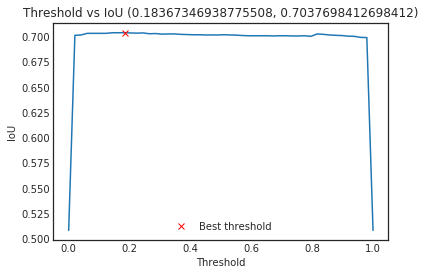

In [26]:
plt.show()


# Another sanity check with adjusted threshold

Again some sample images with the adjusted threshold.


In [ ]:
# max_images = 60
# grid_width = 15
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(ids_valid[:max_images]):
#     img = train_df.loc[idx].images
#     mask = train_df.loc[idx].masks
#     pred = preds_valid[i]
#     ax = axs[int(i / grid_width), i % grid_width]
#     ax.imshow(img, cmap="Greys")
#     ax.imshow(mask, alpha=0.3, cmap="Greens")
#     ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
#     ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
#     ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
#     ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
# plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")


# Submission

Load, predict and submit the test image predictions.


In [ ]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
x_test = np.array([reflect_pad(np.array(load_img("test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)
# Create depth layer
del x_train,y_train,x_valid,y_valid
# x_test_d = [np.ones((DPT_SIZE,DPT_SIZE,1)) * (test_df.loc[i]["z"] / MAX_DEPTH)
#                      for i in tqdm_notebook(test_df.index)] 
# x_test_d = np.array(x_test_d).reshape(-1, DPT_SIZE, DPT_SIZE, 1)
# x_test_d.shape
preds_test = predit_with_one_fold(0,x_test)[:,27:229,27:229,:]

# preds_test = predit_with_kfolds(K_flods,x_test)[:,27:229,27:229,:]
# preds_test = model.predict({'img': x_test, 'depth': x_test_d})
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > 
            threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')